In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sibling_directory = os.path.join(parent_directory,'data')
processed_directory = os.path.join(sibling_directory, 'processed')

In [14]:
feather_file_path = os.path.join(processed_directory, 'icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather')
df = feather.read_feather(feather_file_path)
df = df1[['abs_event_time', 'stay_id','O2 saturation pulseoxymetry','Arterial Blood Pressure mean','Bilirubin, Total','Platelet Count','Creatinine','GCS - Eye Opening','GCS - Motor Response','GCS - Verbal Response']]
df['abs_event_time'] = pd.to_datetime(df['abs_event_time'])
print(df.columns)

Index(['abs_event_time', 'stay_id', 'O2 saturation pulseoxymetry',
       'Arterial Blood Pressure mean', 'Bilirubin, Total', 'Platelet Count',
       'Creatinine', 'GCS - Eye Opening', 'GCS - Motor Response',
       'GCS - Verbal Response'],
      dtype='object')


In [18]:
def calculate_SOFA(SpO2, gcs_eye_opening, gcs_motor_response, gcs_verbal_response, platelet_count, bilirubin, mean_arterial_pressure, creatinine):
    # Calculate SOFA score components
    respiratory_score = 0
    cardiovascular_score = 0
    liver_score = 0
    coagulation_score = 0
    renal_score = 0
    gcs_eye_opening = 0
    gcs_motor_response = 0
    gcs_verbal_response = 0
    gcs_score = 0

    # Respiratory component
    if SpO2 < 90:
       respiratory_score = 4
    elif SpO2 < 92 and SpO2 >= 90:
        respiratory_score = 3
    elif SpO2 < 94 and SpO2 >= 92:
        respiratory_score = 2
    elif SpO2 < 96 and SpO2 >= 94:
        respiratory_score = 1
    elif SpO2 >= 96:
        respiratory_score = 0

    # Cardiovascular component (MAP)
    if mean_arterial_pressure < 40:
        cardiovascular_score = 4
    if mean_arterial_pressure >= 40 and mean_arterial_pressure < 50:
        cardiovascular_score = 3
    if mean_arterial_pressure >= 50 and mean_arterial_pressure < 60:
        cardiovascular_score = 2
    if mean_arterial_pressure >= 60 and mean_arterial_pressure < 70:
        cardiovascular_score = 1
    if mean_arterial_pressure >= 70:
        cardiovascular_score = 0

    # Liver component
    if bilirubin >= 12.0:
        liver_score = 4
    if bilirubin < 12.0 and bilirubin >= 6.0:
        liver_score = 3
    if bilirubin < 6.0 and bilirubin >= 2.0:
        liver_score = 2
    if bilirubin < 2.0 and bilirubin >= 1.2:
        liver_score = 1
    if bilirubin < 1.2:
        liver_score = 0

    # Coagulation component
    if platelet_count <= 20:
        coagulation_score = 4
    elif platelet_count >= 21 and platelet_count <= 50:
        coagulation_score = 3
    elif platelet_count >= 51 and platelet_count <= 100:
        coagulation_score = 2
    elif platelet_count >= 101 and platelet_count <= 150:
        coagulation_score = 1
    elif platelet_count > 150:
        coagulation_score = 0

    # Renal component
    if creatinine > 5:
        renal_score = 4
    elif creatinine >= 3.5 and creatinine <= 4.9:
        renal_score = 3
    elif creatinine >= 2.0 and creatinine <= 3.4:
        renal_score = 2
    elif creatinine >= 1.2 and creatinine <= 1.9:
        renal_score = 1
    elif creatinine < 1.2:
        renal_score = 0

    # Glasgow Coma Scale
    gcs_score = gcs_eye_opening + gcs_motor_response + gcs_verbal_response
    if gcs_score < 6:
        gcs = 4
    elif gcs_score < 10 and gcs_score >= 6:
        gcs = 3
    elif gcs_score < 13 and gcs_score >= 10:
        gcs = 2
    elif gcs_score < 15 and gcs_score >= 13:
        gcs = 1
    elif gcs_score == 15:
        gcs = 0


    # Calculate total SOFA score
    total_SOFA = respiratory_score + cardiovascular_score + liver_score + coagulation_score + renal_score + gcs

    return total_SOFA




In [20]:
# Forward fill missing values along each column
df_ffilled = df.ffill()

# Backward fill missing values along each column for initial 0 values
df_filled = df_ffilled.bfill()

# Calculate SOFA scores for each row using filled data
df_filled['SOFA_score'] = df_filled.apply(lambda row: calculate_SOFA(row['O2 saturation pulseoxymetry'], row['Arterial Blood Pressure mean'], row['Bilirubin, Total'], row['Platelet Count'], row['GCS - Motor Response'], row['GCS - Eye Opening'], row['Creatinine'], row['GCS - Verbal Response']), axis=1)

#Display the dataframe with calculated SOFA scores
print(df_filled[['abs_event_time', 'stay_id',  'SOFA_score']])



          abs_event_time   stay_id  SOFA_score
0    1970-01-01 01:00:00  30057454          16
1    1970-01-01 02:00:00  30057454          15
2    1970-01-01 03:00:00  30057454          15
3    1970-01-01 04:00:00  30057454          15
4    1970-01-01 05:00:00  30057454          16
...                  ...       ...         ...
2911 1970-01-01 20:00:00  39880770          14
2912 1970-01-01 21:00:00  39880770          14
2913 1970-01-01 22:00:00  39880770          14
2914 1970-01-01 23:00:00  39880770          14
2915 1970-01-02 00:00:00  39880770          14

[2916 rows x 3 columns]


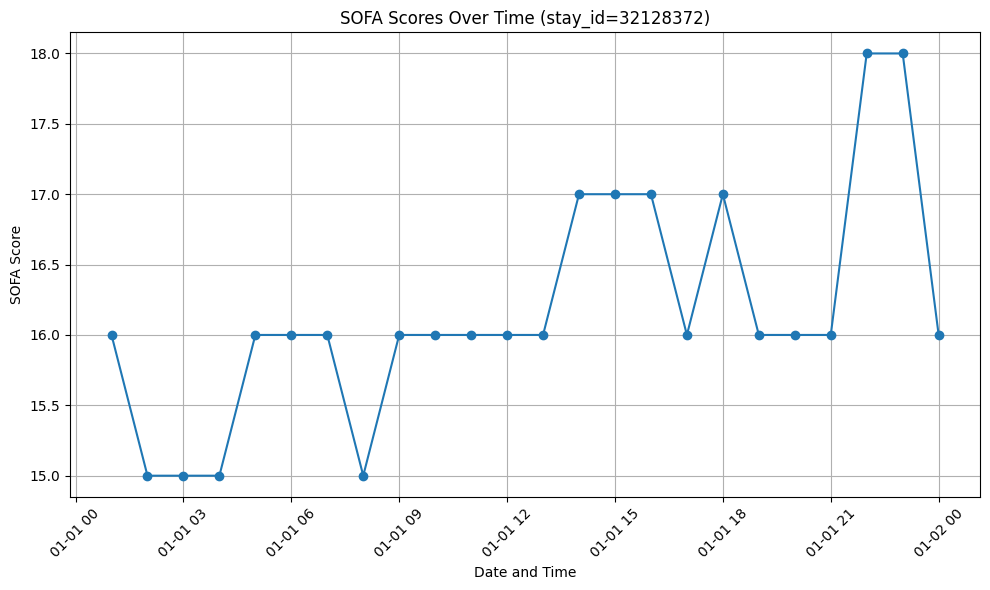

In [22]:
# Filter data for stay_id=32128372
filtered_df = df_filled[df_filled['stay_id'] == 30057454]

# Plot SOFA scores for stay_id=32128372 over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['abs_event_time'], filtered_df['SOFA_score'], marker='o', linestyle='-')
plt.xlabel('Date and Time')
plt.ylabel('SOFA Score')
plt.title('SOFA Scores Over Time (stay_id=32128372)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#plt.xticks(pd.date_range(filtered_df['abs_event_time'].iloc[0], filtered_df['abs_event_time'].iloc[-1], periods=30))  # Set the number of ticks on the x-axis
plt.tight_layout() 
plt.grid(True)
plt.show()